<h1>Trabajamos con datos de anomalias oni y promedios mensuales</h1>

In [1]:
#import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
#from tools import search_oni
import skimage
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
# Load data
data_oni = pd.read_csv('E:\Proyecto de Grado\Data\ONI_NOAA - copia.txt', sep="\s+")

# Create new columns
data_oni['TIME'] = pd.to_datetime(
    dict(year=data_oni["YR"], month=data_oni["MON"], day=1), format='%Y-%m')
data_oni['category'] = data_oni['ANOM'].apply(
    lambda x: 'Niño' if x >= 0.5 else 'Neutro' if x > -0.5 else 'Niña')

# Column to classify data by month and category
data_oni["month_anomaly"] = data_oni["MON"].astype(
    "str") + " " + data_oni["category"]

In [3]:
ds_currents = xr.open_dataset('E:\Proyecto de Grado\Data\corrientes_u_v_5m_enero1993_diciembre2020.nc')
ds_monthly = ds_currents.groupby('time.month').mean()
ds_monthly

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 12, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.1063 ... 0.02531
    uo         (month, depth, latitude, longitude) float32 0.1706 ... -0.002202
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [4]:
ds_month_oni = xr.open_dataset(r'E:\Proyecto de Grado\Data\Nueva carpeta\corrientes_month_anomaly.nc')
ds_month_oni

<xarray.Dataset>
Dimensions:        (lon: 372, lat: 205, month_anomaly: 36)
Coordinates:
  * lon            (lon) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * lat            (lat) float32 7.0 7.083 7.167 7.25 ... 23.75 23.83 23.92 24.0
  * month_anomaly  (month_anomaly) object '1 Neutro' '1 Niña' ... '9 Niño'
Data variables:
    vo             (month_anomaly, lat, lon) float32 ...
    uo             (month_anomaly, lat, lon) float32 ...

c:\Users\neybe\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


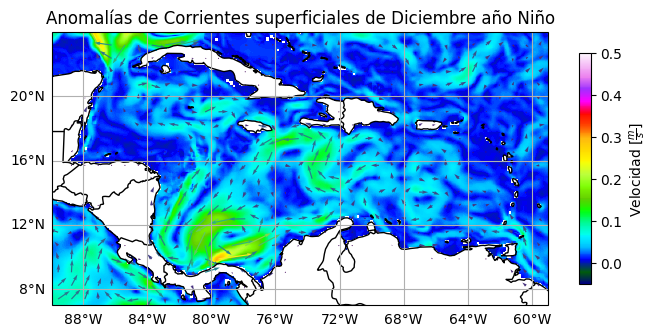

In [97]:
ds_m = ds_monthly.sel({'month': [12]})
lat = ds_m['latitude'].to_numpy()
lon = ds_m['longitude'].to_numpy()
Vm = ds_m["vo"].mean(dim=["month","depth"]).to_numpy()
Um = ds_m["uo"].mean(dim=["month","depth"]).to_numpy()
##############################################################################################################################################
ds_ciclos = ds_month_oni.where(ds_month_oni['month_anomaly'] == "12 Niño")
lato = ds_ciclos['lat'].to_numpy()
lono = ds_ciclos['lon'].to_numpy()
Vo = ds_ciclos["vo"].mean(dim=["month_anomaly"]).to_numpy()
Uo =     ds_ciclos["uo"].mean(dim=["month_anomaly"]).to_numpy()

V = Vo - Vm
U = Uo - Um

X, Y = np.meshgrid(lon, lat)

x = skimage.measure.block_reduce(X, (10, 10), np.nanmean)
y = skimage.measure.block_reduce(Y, (10, 10), np.nanmean)
u = skimage.measure.block_reduce(U, (10, 10), np.nanmean)
v = skimage.measure.block_reduce(V, (10, 10), np.nanmean)

# Crea una figura y ejes con la proyección de latitud y longitud
fig, ax = plt.subplots(1, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
loc = ticker.MultipleLocator(4)

# Agrega el mapa base (costas, límites de países, etc.)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

#genera una capa raster
# Usa origin='lower' para mostrar los datos correctamente
# Usa vmin=0 y vmax=1.5 para establecer la escala de la barra de colores
R = ax.imshow(np.sqrt(U**2 + V**2), extent=[lon.min(), lon.max(), lat.min(), lat.max()],
           cmap='gist_ncar', origin='lower', vmin=-0.05, vmax=0.5)

# Crea el gráfico de vectores
Q = ax.quiver(x, y, u, v, np.sqrt(u**2 + v**2), scale=3, color= 'w')

# Agrega una barra de color asociada a la magnitud de los vectores
plt.colorbar(R, label=r"Velocidad [$\frac{m}{s}$]", shrink = 0.5)

# Establece los límites del mapa y etiquetas de los ejes
ax.set(ylim=(lat.min(), lat.max()), xlim=(lon.min(), lon.max()))                                                                # Agrega un marco naval con las coordenadas en rojo y con líneas discontinuas
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, xlocs=loc, ylocs=loc)

# Muestra el mapa
plt.title("Anomalías de Corrientes superficiales de Diciembre año Niño")
plt.show()
